In [4]:
# Import required libraries first
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import joblib

# Load the preprocessed data and objects from Part 1
try:
    # If you saved variables in Part 1, load them here
    data_objects = joblib.load('preprocessed_data.pkl')
    X_train_encoded = data_objects['X_train_encoded']
    X_test_encoded = data_objects['X_test_encoded']
    y_train = data_objects['y_train']
    y_test = data_objects['y_test']
    scaler = data_objects['scaler']
    cols_to_scale = data_objects['cols_to_scale']
    
    print("✅ Successfully loaded preprocessed data from Part 1")
    print(f"Training set shape: {X_train_encoded.shape}")
    print(f"Test set shape: {X_test_encoded.shape}")
    
except FileNotFoundError:
    print("❌ Preprocessed data file not found. Please run the code below to recreate the preprocessing.")

✅ Successfully loaded preprocessed data from Part 1
Training set shape: (37488, 13)
Test set shape: (12497, 13)


<h3 align="center" style="color:blue">Model Training</h3>

### Attempt 1

1. Logistic Regression, RandomForest & XGB
1. No handling of class imbalance

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11423
           1       0.85      0.72      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.91      0.85      0.88     12497
weighted avg       0.96      0.96      0.96     12497



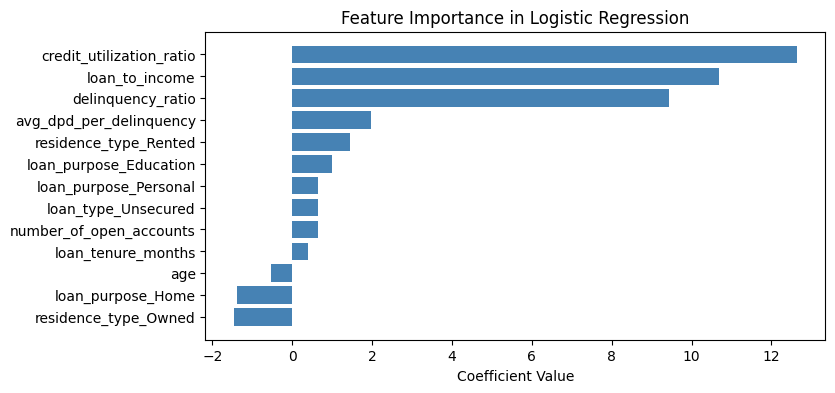

In [6]:
feature_importance = model.coef_[0]

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train_encoded.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()

In [7]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11423
           1       0.85      0.71      0.77      1074

    accuracy                           0.96     12497
   macro avg       0.91      0.85      0.88     12497
weighted avg       0.96      0.96      0.96     12497



In [8]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11423
           1       0.82      0.76      0.79      1074

    accuracy                           0.96     12497
   macro avg       0.90      0.87      0.88     12497
weighted avg       0.96      0.96      0.96     12497



Since there is not much difference between XGB and Logistic, we will choose LogisticRegression as a candidate for our RandomizedSearchCV candidate it has a better interpretation.

#### RandomizedSearch CV for Attempt 1: Logistic Regression

In [9]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'C': np.logspace(-4, 4, 20),  # Logarithmically spaced values from 10^-4 to 10^4
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg']   # Algorithm to use in the optimization problem
}

# Create the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000)  # Increased max_iter for convergence

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='f1',
    cv=3,  # 5-fold cross-validation
    verbose=2,
    random_state=42,  # Set a random state for reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train_encoded, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'solver': 'saga', 'C': np.float64(3792.690190732246)}
Best Score: 0.7578820896729832
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11423
           1       0.83      0.74      0.78      1074

    accuracy                           0.96     12497
   macro avg       0.90      0.86      0.88     12497
weighted avg       0.96      0.96      0.96     12497



#### RandomizedSearch CV for Attempt 1: XGBoost

In [10]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 2, 3, 5, 7, 10],
    'reg_alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],  # L1 regularization term
    'reg_lambda': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]  # L2 regularization term
}

xgb = XGBClassifier()

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100,
                                   scoring='f1', cv=3, verbose=1, n_jobs=-1, random_state=42)

random_search.fit(X_train_encoded, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.9, 'scale_pos_weight': 2, 'reg_lambda': 10.0, 'reg_alpha': 10.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Best Score: 0.7871111337608833
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11423
           1       0.78      0.82      0.80      1074

    accuracy                           0.96     12497
   macro avg       0.88      0.90      0.89     12497
weighted avg       0.97      0.96      0.96     12497



### Attempt 2

1. Logistic Regression & XGB
1. Handle Class Imbalance Using Under Sampling

In [11]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_encoded, y_train)
y_train_res.value_counts()

default
0    3223
1    3223
Name: count, dtype: int64

In [12]:
model = LogisticRegression()
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     11423
           1       0.51      0.96      0.67      1074

    accuracy                           0.92     12497
   macro avg       0.75      0.93      0.81     12497
weighted avg       0.95      0.92      0.93     12497



In [13]:
model = XGBClassifier(**random_search.best_params_)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     11423
           1       0.52      0.99      0.68      1074

    accuracy                           0.92     12497
   macro avg       0.76      0.95      0.82     12497
weighted avg       0.96      0.92      0.93     12497



### Attempt 3

1. Logistic Regression
1. Handle Class Imbalance Using SMOTE Tomek
1. Parameter tunning using optuna

In [14]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train_encoded, y_train)
y_train_smt.value_counts()

default
0    34195
1    34195
Name: count, dtype: int64

In [15]:
model = LogisticRegression()
model.fit(X_train_smt, y_train_smt)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.55      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.77      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



In [16]:
import optuna
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score

In [17]:
# Define the objective function for Optuna
def objective(trial):
    param = {
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),  # Logarithmically spaced values
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'newton-cg']),  # Solvers
        'tol': trial.suggest_float('tol', 1e-6, 1e-1, log=True),  # Logarithmically spaced values for tolerance
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])  # Class weights
    }

    model = LogisticRegression(**param, max_iter=10000)
    
    # Calculate the cross-validated f1_score
    f1_scorer = make_scorer(f1_score, average='macro')
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)
    
    return np.mean(scores)

study_logistic = optuna.create_study(direction='maximize')
study_logistic.optimize(objective, n_trials=50)

[I 2025-08-13 13:31:21,966] A new study created in memory with name: no-name-261146e9-598f-4097-b5ef-7a6594e0e57b
[I 2025-08-13 13:31:22,064] Trial 0 finished with value: 0.8391348698586237 and parameters: {'C': 0.00038208552531297953, 'solver': 'liblinear', 'tol': 0.001782781908182262, 'class_weight': None}. Best is trial 0 with value: 0.8391348698586237.
[I 2025-08-13 13:31:22,219] Trial 1 finished with value: 0.9456616928471101 and parameters: {'C': 2.7684786375496087, 'solver': 'liblinear', 'tol': 1.083018398314285e-05, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9456616928471101.
[I 2025-08-13 13:31:22,366] Trial 2 finished with value: 0.9456355013159934 and parameters: {'C': 213.52738005779844, 'solver': 'liblinear', 'tol': 0.0002543172201479757, 'class_weight': None}. Best is trial 1 with value: 0.9456616928471101.
[I 2025-08-13 13:31:22,620] Trial 3 finished with value: 0.9185566816819876 and parameters: {'C': 0.002809401355546972, 'solver': 'saga', 'tol': 7.4872

In [18]:
print('Best trial:')
trial = study_logistic.best_trial
print('  F1-score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
best_model_logistic = LogisticRegression(**study_logistic.best_params)
best_model_logistic.fit(X_train_smt, y_train_smt)

# Evaluate on the test set
y_pred = best_model_logistic.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

Best trial:
  F1-score: 0.9461469522669045
  Params: 
    C: 18.616056424822457
    solver: saga
    tol: 0.019634006398586985
    class_weight: balanced
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     11423
           1       0.59      0.93      0.72      1074

    accuracy                           0.94     12497
   macro avg       0.79      0.93      0.84     12497
weighted avg       0.96      0.94      0.94     12497



### Attempt 4

1. XGBoost
1. Handle Class Imbalance Using SMOTE Tomek
1. Parameter tunning using optuna

In [19]:
# Define the objective function for Optuna
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'verbosity': 0,
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10)
    }

    model = XGBClassifier(**param)
    
    # Calculate the cross-validated f1_score
    f1_scorer = make_scorer(f1_score, average='macro')
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=3, scoring=f1_scorer, n_jobs=-1)
    
    return np.mean(scores)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=50)

[I 2025-08-13 13:31:29,611] A new study created in memory with name: no-name-c5ff0182-51f9-43e4-8783-7b6d17463586
[I 2025-08-13 13:31:30,124] Trial 0 finished with value: 0.970334282652126 and parameters: {'lambda': 9.174458004240714, 'alpha': 0.014917869232508573, 'subsample': 0.7428942426270146, 'colsample_bytree': 0.9028365731015905, 'max_depth': 5, 'eta': 0.20284706694177956, 'gamma': 0.3342019336739155, 'scale_pos_weight': 1.5567253516974333, 'min_child_weight': 4, 'max_delta_step': 7}. Best is trial 0 with value: 0.970334282652126.
[I 2025-08-13 13:31:30,847] Trial 1 finished with value: 0.9761326961390902 and parameters: {'lambda': 0.003635516207437958, 'alpha': 0.0019973174395209337, 'subsample': 0.5040668704338015, 'colsample_bytree': 0.7731947147459945, 'max_depth': 9, 'eta': 0.17668450045467038, 'gamma': 1.274139482978398, 'scale_pos_weight': 1.2020208046016028, 'min_child_weight': 2, 'max_delta_step': 3}. Best is trial 1 with value: 0.9761326961390902.
[I 2025-08-13 13:31:3

In [20]:
print('Best trial:')
trial = study_xgb.best_trial
print('  F1-score: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
    
best_params = study_xgb.best_params
best_model_xgb = XGBClassifier(**best_params)
best_model_xgb.fit(X_train_smt, y_train_smt)

# Evaluate on the test set
y_pred = best_model_xgb.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

Best trial:
  F1-score: 0.9767460219357694
  Params: 
    lambda: 0.406168024998387
    alpha: 0.2988940670668339
    subsample: 0.522147332033442
    colsample_bytree: 0.752064096881186
    max_depth: 9
    eta: 0.25019473053740876
    gamma: 0.32398673909847614
    scale_pos_weight: 1.1344315674101568
    min_child_weight: 1
    max_delta_step: 4
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     11423
           1       0.75      0.83      0.79      1074

    accuracy                           0.96     12497
   macro avg       0.87      0.90      0.88     12497
weighted avg       0.96      0.96      0.96     12497



## Model Evaluation : ROC/AUC

In [21]:
y_pred = best_model_logistic.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     11423
           1       0.59      0.93      0.72      1074

    accuracy                           0.94     12497
   macro avg       0.79      0.93      0.84     12497
weighted avg       0.96      0.94      0.94     12497



In [22]:
from sklearn.metrics import roc_curve

probabilities = best_model_logistic.predict_proba(X_test_encoded)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

fpr[:5], tpr[:5], thresholds[:5]

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.75426771e-05,
        8.75426771e-05]),
 array([0.        , 0.0009311 , 0.15828678, 0.15828678, 0.17597765]),
 array([       inf, 1.        , 0.99937392, 0.99934933, 0.99916881]))

In [23]:
from sklearn.metrics import auc

area = auc(fpr, tpr)
area

np.float64(0.983448809786391)

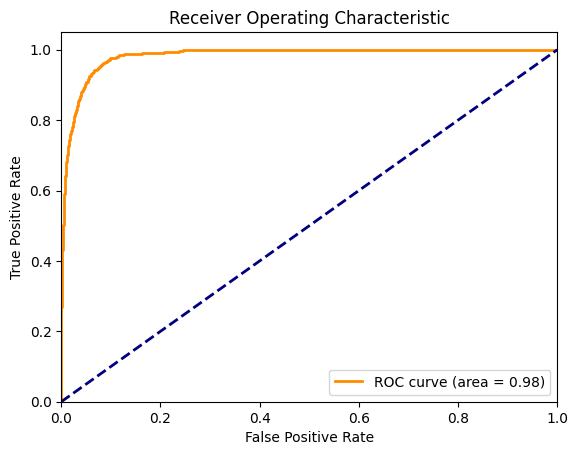

In [24]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Model Evaluation : Rankordering, KS statistic, Gini coeff

In [25]:
probabilities = best_model_logistic.predict_proba(X_test_encoded)[:,1]

df_eval = pd.DataFrame({
    'Default Truth': y_test,
    'Default Probability': probabilities
})
df_eval.head(3)

,Default Truth,Default Probability
19205,0,0.414676
15514,0,0.000007
30367,0,0.003946


In [26]:
df_eval['Decile'] = pd.qcut(df_eval['Default Probability'], 10, labels=False, duplicates='drop')
df_eval.head(3)

,Default Truth,Default Probability,Decile
19205,0,0.414676,8
15514,0,0.000007,2
30367,0,0.003946,6


In [27]:
df_eval[df_eval.Decile==8]['Default Probability'].describe()

count    1250.000000
mean        0.423105
std         0.183703
min         0.165023
25%         0.254713
50%         0.396926
75%         0.576458
max         0.778006
Name: Default Probability, dtype: float64

In [28]:
df_decile = df_eval.groupby('Decile').apply(lambda x: pd.Series({
    'Minimum Probability': x['Default Probability'].min(),
    'Maximum Probability': x['Default Probability'].max(),
    'Events': x['Default Truth'].sum(),
    'Non-events': x['Default Truth'].count() - x['Default Truth'].sum(),    
}))
df_decile.reset_index(inplace=True)
df_decile

C:\Users\Himan\AppData\Local\Temp\ipykernel_20708\4037021561.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_decile = df_eval.groupby('Decile').apply(lambda x: pd.Series({


,Decile,Minimum Probability,Maximum Probability,Events,Non-events
0,0,6.737829e-10,4.657032e-07,0.0,1250.0
1,1,4.662504e-07,3.793587e-06,0.0,1250.0
2,2,3.793945e-06,1.952332e-05,0.0,1249.0
3,3,1.954052e-05,9.916583e-05,0.0,1250.0
4,4,9.923764e-05,5.156361e-04,0.0,1250.0
5,5,5.158968e-04,3.004234e-03,0.0,1249.0
6,6,3.009209e-03,2.073365e-02,6.0,1244.0
7,7,2.075376e-02,1.634148e-01,9.0,1240.0
8,8,1.650233e-01,7.780063e-01,164.0,1086.0
9,9,7.786732e-01,1.000000e+00,895.0,355.0


In [29]:
df_decile['Event Rate'] = df_decile['Events']*100 / (df_decile['Events']+df_decile['Non-events'])
df_decile['Non-event Rate'] = df_decile['Non-events']*100 / (df_decile['Events']+df_decile['Non-events'])
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate
0,0,6.737829e-10,4.657032e-07,0.0,1250.0,0.000000,100.000000
1,1,4.662504e-07,3.793587e-06,0.0,1250.0,0.000000,100.000000
2,2,3.793945e-06,1.952332e-05,0.0,1249.0,0.000000,100.000000
3,3,1.954052e-05,9.916583e-05,0.0,1250.0,0.000000,100.000000
4,4,9.923764e-05,5.156361e-04,0.0,1250.0,0.000000,100.000000
5,5,5.158968e-04,3.004234e-03,0.0,1249.0,0.000000,100.000000
6,6,3.009209e-03,2.073365e-02,6.0,1244.0,0.480000,99.520000
7,7,2.075376e-02,1.634148e-01,9.0,1240.0,0.720576,99.279424
8,8,1.650233e-01,7.780063e-01,164.0,1086.0,13.120000,86.880000
9,9,7.786732e-01,1.000000e+00,895.0,355.0,71.600000,28.400000


In [30]:
df_decile = df_decile.sort_values(by='Decile', ascending=False).reset_index(drop=True)
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate
0,9,7.786732e-01,1.000000e+00,895.0,355.0,71.600000,28.400000
1,8,1.650233e-01,7.780063e-01,164.0,1086.0,13.120000,86.880000
2,7,2.075376e-02,1.634148e-01,9.0,1240.0,0.720576,99.279424
3,6,3.009209e-03,2.073365e-02,6.0,1244.0,0.480000,99.520000
4,5,5.158968e-04,3.004234e-03,0.0,1249.0,0.000000,100.000000
5,4,9.923764e-05,5.156361e-04,0.0,1250.0,0.000000,100.000000
6,3,1.954052e-05,9.916583e-05,0.0,1250.0,0.000000,100.000000
7,2,3.793945e-06,1.952332e-05,0.0,1249.0,0.000000,100.000000
8,1,4.662504e-07,3.793587e-06,0.0,1250.0,0.000000,100.000000
9,0,6.737829e-10,4.657032e-07,0.0,1250.0,0.000000,100.000000


In [31]:
df_decile['Cum Events'] =  df_decile['Events'].cumsum()
df_decile['Cum Non-events'] =  df_decile['Non-events'].cumsum()
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events
0,9,7.786732e-01,1.000000e+00,895.0,355.0,71.600000,28.400000,895.0,355.0
1,8,1.650233e-01,7.780063e-01,164.0,1086.0,13.120000,86.880000,1059.0,1441.0
2,7,2.075376e-02,1.634148e-01,9.0,1240.0,0.720576,99.279424,1068.0,2681.0
3,6,3.009209e-03,2.073365e-02,6.0,1244.0,0.480000,99.520000,1074.0,3925.0
4,5,5.158968e-04,3.004234e-03,0.0,1249.0,0.000000,100.000000,1074.0,5174.0
5,4,9.923764e-05,5.156361e-04,0.0,1250.0,0.000000,100.000000,1074.0,6424.0
6,3,1.954052e-05,9.916583e-05,0.0,1250.0,0.000000,100.000000,1074.0,7674.0
7,2,3.793945e-06,1.952332e-05,0.0,1249.0,0.000000,100.000000,1074.0,8923.0
8,1,4.662504e-07,3.793587e-06,0.0,1250.0,0.000000,100.000000,1074.0,10173.0
9,0,6.737829e-10,4.657032e-07,0.0,1250.0,0.000000,100.000000,1074.0,11423.0


In [32]:
df_decile['Cum Event Rate'] = df_decile['Cum Events'] * 100 / df_decile['Events'].sum()
df_decile['Cum Non-event Rate'] = df_decile['Cum Non-events']*100 / df_decile['Non-events'].sum()
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate
0,9,7.786732e-01,1.000000e+00,895.0,355.0,71.600000,28.400000,895.0,355.0,83.333333,3.107765
1,8,1.650233e-01,7.780063e-01,164.0,1086.0,13.120000,86.880000,1059.0,1441.0,98.603352,12.614900
2,7,2.075376e-02,1.634148e-01,9.0,1240.0,0.720576,99.279424,1068.0,2681.0,99.441341,23.470192
3,6,3.009209e-03,2.073365e-02,6.0,1244.0,0.480000,99.520000,1074.0,3925.0,100.000000,34.360501
4,5,5.158968e-04,3.004234e-03,0.0,1249.0,0.000000,100.000000,1074.0,5174.0,100.000000,45.294581
5,4,9.923764e-05,5.156361e-04,0.0,1250.0,0.000000,100.000000,1074.0,6424.0,100.000000,56.237416
6,3,1.954052e-05,9.916583e-05,0.0,1250.0,0.000000,100.000000,1074.0,7674.0,100.000000,67.180250
7,2,3.793945e-06,1.952332e-05,0.0,1249.0,0.000000,100.000000,1074.0,8923.0,100.000000,78.114331
8,1,4.662504e-07,3.793587e-06,0.0,1250.0,0.000000,100.000000,1074.0,10173.0,100.000000,89.057165
9,0,6.737829e-10,4.657032e-07,0.0,1250.0,0.000000,100.000000,1074.0,11423.0,100.000000,100.000000


In [33]:
df_decile['KS'] = abs(df_decile['Cum Event Rate'] - df_decile['Cum Non-event Rate'])
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate,KS
0,9,7.786732e-01,1.000000e+00,895.0,355.0,71.600000,28.400000,895.0,355.0,83.333333,3.107765,80.225568
1,8,1.650233e-01,7.780063e-01,164.0,1086.0,13.120000,86.880000,1059.0,1441.0,98.603352,12.614900,85.988452
2,7,2.075376e-02,1.634148e-01,9.0,1240.0,0.720576,99.279424,1068.0,2681.0,99.441341,23.470192,75.971149
3,6,3.009209e-03,2.073365e-02,6.0,1244.0,0.480000,99.520000,1074.0,3925.0,100.000000,34.360501,65.639499
4,5,5.158968e-04,3.004234e-03,0.0,1249.0,0.000000,100.000000,1074.0,5174.0,100.000000,45.294581,54.705419
5,4,9.923764e-05,5.156361e-04,0.0,1250.0,0.000000,100.000000,1074.0,6424.0,100.000000,56.237416,43.762584
6,3,1.954052e-05,9.916583e-05,0.0,1250.0,0.000000,100.000000,1074.0,7674.0,100.000000,67.180250,32.819750
7,2,3.793945e-06,1.952332e-05,0.0,1249.0,0.000000,100.000000,1074.0,8923.0,100.000000,78.114331,21.885669
8,1,4.662504e-07,3.793587e-06,0.0,1250.0,0.000000,100.000000,1074.0,10173.0,100.000000,89.057165,10.942835
9,0,6.737829e-10,4.657032e-07,0.0,1250.0,0.000000,100.000000,1074.0,11423.0,100.000000,100.000000,0.000000


To assess whether rank ordering is followed, we should look at whether higher deciles (those with higher predicted probabilities) have higher event rates compared to lower deciles. Rank ordering means that as you move from the top decile to the bottom decile, the event rate should generally decrease.

Non-Events - termed as good (customers) who do not default. Events - termed as bad (customers) who default.

Events and Non-Events terms are interchanged based on usecase to usecase.

eg: for marketing usecase, which customer to reach out (who will take loan based on offers) will be events - here it will termed as good, and the customers who will not take loans will be non-events (bad).

**Insights from the Decile Table**

1. Top Deciles

* The first decile (Decile 9) has a high event rate of 72.00% and a non-event rate of 28.00%. This indicates that the model is highly confident in predicting events in this decile.
* The second decile (Decile 8) also shows a significant event rate of 12.72%, with a cumulative event rate reaching 98.6%.

2. Middle Deciles:

* Deciles 7 and 6 show a significant drop in event rates

3. Lower Deciles:

* Deciles 5 to 0 show zero events, with all predictions being non-events. These deciles collectively have a non-event rate of 100%.

4. KS Statistic:

* The KS statistic, which is the maximum difference between cumulative event rates and cumulative non-event rates, is highest at Decile 8 with a value of 85.98%. This suggests that the model performs best at distinguishing between events and non-events up to this decile.

* The KS value gradually decreases in the following deciles, indicating a decrease in model performance for distinguishing between events and non-events.

**KS Value**

The highest KS value is 85.98%, found at Decile 8. This indicates that the model's performance in distinguishing between events and non-events is most significant at this decile. (If KS is in top 3 decile and score above 40, it is considered a good predictive model.)

In [34]:
gini_coefficient = 2 * area - 1

print("AUC:", area)
print("Gini Coefficient:", gini_coefficient)

AUC: 0.983448809786391
Gini Coefficient: 0.9668976195727821


AUC of 0.98: The model is very good at distinguishing between events and non-events.

Gini coefficient of 0.96: This further confirms that the model is highly effective in its predictions, with almost perfect rank ordering capability.

The Gini coefficient ranges from -1 to 1, where a value closer to 1 signifies a perfect model, 0 indicates a model with no discriminative power, and -1 signifies a perfectly incorrect model.

#### Finalize The Model and Visualize Feature Importance

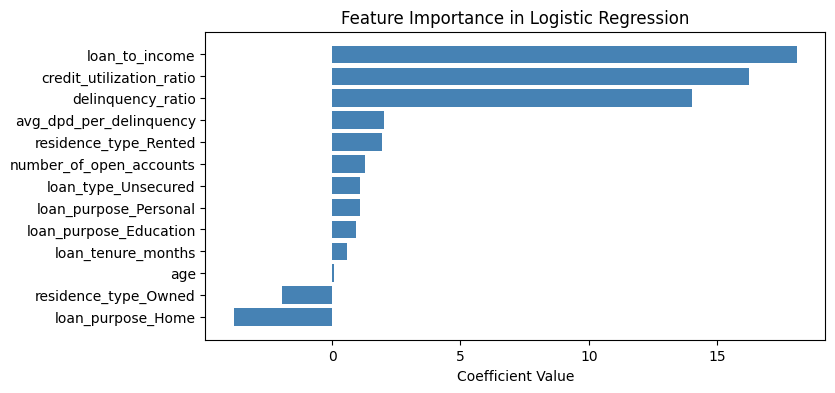

In [35]:
final_model = best_model_logistic

feature_importance = final_model.coef_[0]

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train_encoded.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()

### Save the Model

In [36]:
X_test_encoded.head(2)

,age,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
19205,0.346154,0.754717,0.333333,0.989899,0.550351,0.0,0.0,True,False,False,True,False,False
15514,0.480769,0.226415,1.000000,0.323232,0.220141,0.0,0.0,True,False,True,False,False,False


In [37]:
X_test_encoded.columns

Index(['age', 'loan_tenure_months', 'number_of_open_accounts',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency', 'residence_type_Owned',
       'residence_type_Rented', 'loan_purpose_Education', 'loan_purpose_Home',
       'loan_purpose_Personal', 'loan_type_Unsecured'],
      dtype='object')

In [38]:
cols_to_scale

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [39]:
X_train_encoded.columns

Index(['age', 'loan_tenure_months', 'number_of_open_accounts',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency', 'residence_type_Owned',
       'residence_type_Rented', 'loan_purpose_Education', 'loan_purpose_Home',
       'loan_purpose_Personal', 'loan_type_Unsecured'],
      dtype='object')

In [40]:
from joblib import dump

model_data = {
    'model': final_model,
    'features': X_train_encoded.columns,
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(model_data, 'artifacts/model_data.joblib')

['artifacts/model_data.joblib']

In [41]:
final_model.coef_, final_model.intercept_

(array([[ 0.05631441,  0.56729745,  1.28596579, 16.23472609, 18.12453359,
         14.039591  ,  2.03612612, -1.94632419,  1.93189398,  0.93167193,
         -3.83941592,  1.09549296,  1.09549296]]),
 array([-21.48082388]))